In [1]:
%load_ext autoreload
%autoreload 2
%run prerun.py
%matplotlib inline

device = torch.device('cuda:1')

SOLVERS:  ['dopri5', 'bdf', 'rk4', 'midpoint', 'adams', 'explicit_adams', 'fixed_adams']
{'tanh': Tanh(), 'relu': ReLU(), 'softplus': Softplus(beta=1, threshold=20), 'elu': ELU(alpha=1.0), 'swish': Swish(), 'square': Lambda(), 'identity': Lambda()}


## Data

In [2]:
sys.path.append('../')
from model import YModel, OptLoss
from utils import generate_data
y_sampler = YModel()
mu_range = (-10, 10)
n_samples = 10000
x, conditions = generate_data(y_sampler, device, n_samples=n_samples, mu_range=mu_range, mu_dim=2)

print(x.shape, conditions.shape)

torch.Size([10000, 1]) torch.Size([10000, 3])


## Define model

In [3]:
regularization_fns = None
# regularization_fns, regularization_coeffs = create_regularization_fns()

model = build_model_tabular(dims=1, 
                            condition_dim=3,
                            layer_type='concat_v2',
                            num_blocks=3,
                            rademacher=False,
                            nonlinearity='tanh',
                            solver='dopri5',
                            hidden_dims=(128, 128),
                            bn_lag=0.01, 
                            batch_norm=True,
                            regularization_fns=regularization_fns).to(device)
sum(p.numel() for p in model.parameters()  if p.requires_grad)

78068

In [4]:
import torch.utils.data as pytorch_data_utils
BATCH_SIZE = 1024
dataset = torch.utils.data.TensorDataset(x, conditions)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training

iter 99: loss = 2.363 2.5e-05


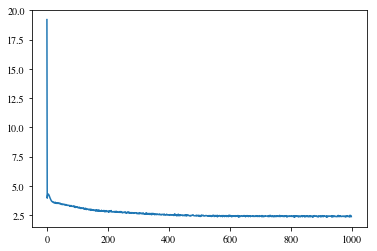

In [5]:
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(model.parameters()) 
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)
losses = []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100)

for epoch in tqdm(range(100)):
    for x_batch, cond_batch in tqdm(dataloader):
        x_batch = x_batch.to(device)
        cond_batch = cond_batch.to(device)

        loss = compute_loss(model, data=x_batch, condition=cond_batch)

        if loss != loss:
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step(loss)

    clear_output()
    print('iter %s:' % epoch, 'loss = %.3f' % loss, optimizer.param_groups[0]['lr'])
    plt.figure()
    plt.plot(losses)
    # plt.ylim(1.1, 3)
    plt.show()

## Evalutation

In [6]:
model.eval();
model.cpu();
sample_fn, density_fn = get_transforms(model)

In [7]:
mu_range_test = (-20, 20)
batch_size = 100
mu_samples = 5000

mu = dist.Uniform(*mu_range_test).sample([mu_samples, 2]) # .to(device)
mu.requires_grad=True
mu_r = mu.repeat(1, batch_size).view(-1, 2)
x_r = y_sampler.x_dist.sample(torch.Size([len(mu) * batch_size , 1])) # .to(device)

In [8]:
samples = sample_fn(torch.randn(mu_samples * batch_size, 1).float(), torch.cat([mu_r, x_r],dim=1))
rs = OptLoss.SigmoidLoss(samples, 5, 10).reshape(-1, batch_size).mean(dim=1)

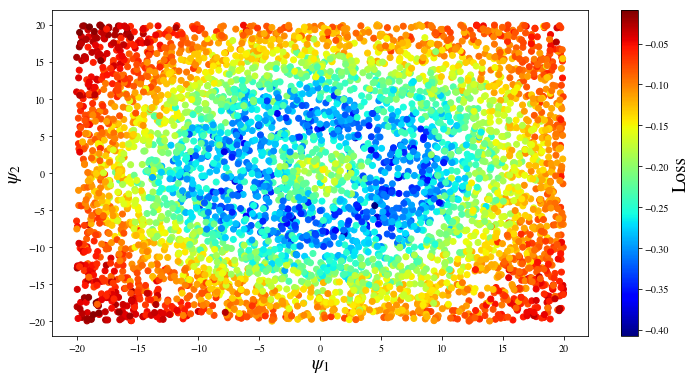

In [9]:
plt.figure(figsize=(12, 6))

plt.scatter(mu[:, 0].cpu().detach().numpy(), mu[:,1].cpu().detach().numpy(), c=rs.cpu().detach().numpy(),  cmap=my_cmap)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

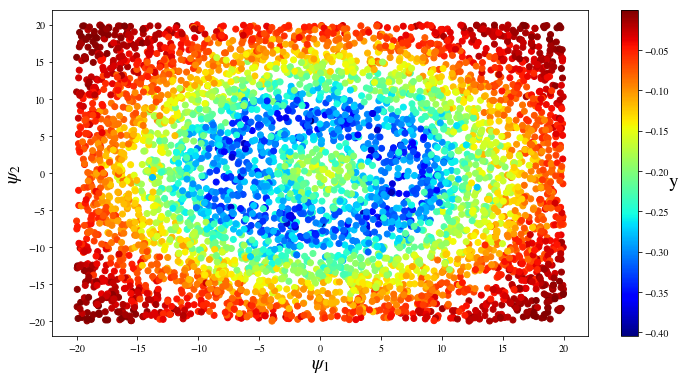

In [10]:
y_sampler.make_condition_sample({'mu': mu_r, 'X': x_r})

y = y_sampler.condition_sample()
c = OptLoss.SigmoidLoss(y, 5, 10).reshape(-1, batch_size).mean(dim=1)
c.sum().backward()
plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), c=c.cpu().detach().numpy(), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.show()

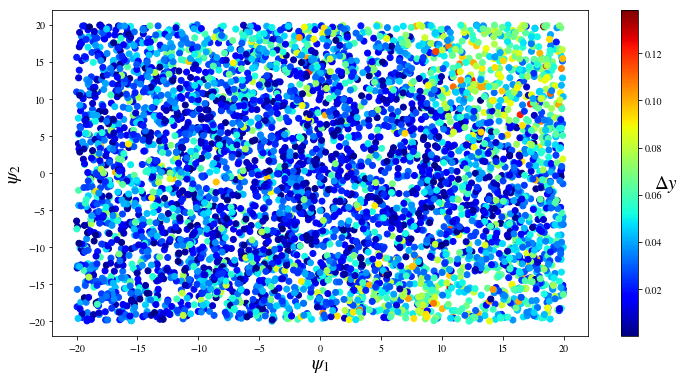

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(mu[:,0].cpu().detach().numpy(), mu[:, 1].cpu().detach().numpy(), c=np.abs((c - rs).detach().cpu().numpy()), cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label(f'$\Delta y$', rotation=360, fontsize=19)
plt.show()

### $\log p(y | x, \mu)$

$$p(y, x, \mu) = p(y | x, \mu) p(x) p(\mu)$$

$$p(x | y, \mu) = ?$$

In [68]:
x_r_batch = torch.randn(batch_size, 1, requires_grad=True, device=device)
x_r_batch_old = x_r_batch.detach().clone().to(device)
y_r_batch = y[:batch_size].detach().to(device)
mu_r_batch = mu_r[:batch_size].detach().to(device)

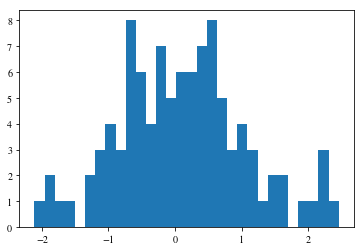

In [69]:
plt.hist(x_r_batch[:batch_size].view(-1).detach().cpu().numpy(), bins=30);

In [70]:
sgd_batch = optim.SGD([x_r_batch], lr=10.)

In [71]:
model.to(device);
sample_fn, density_fn = get_transforms(model)

-1.7731750011444092


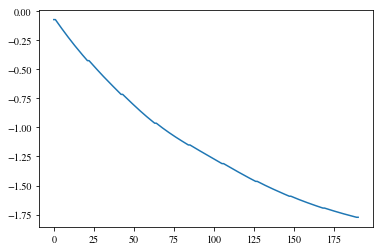

In [72]:
log_densities = []
for i in tqdm(range(200)):
    log_density = -density_fn(y_r_batch, torch.cat([mu_r_batch, x_r_batch], dim=1)).mean()
    log_density.backward()
    sgd_batch.step()
    sgd_batch.zero_grad()
    log_densities.append(log_density.item())
    if i % 20 == 0:
        clear_output()
        print(log_density.item())
        log_densities.append(log_density.item())
        plt.figure()
        plt.plot(log_densities)
        plt.show()

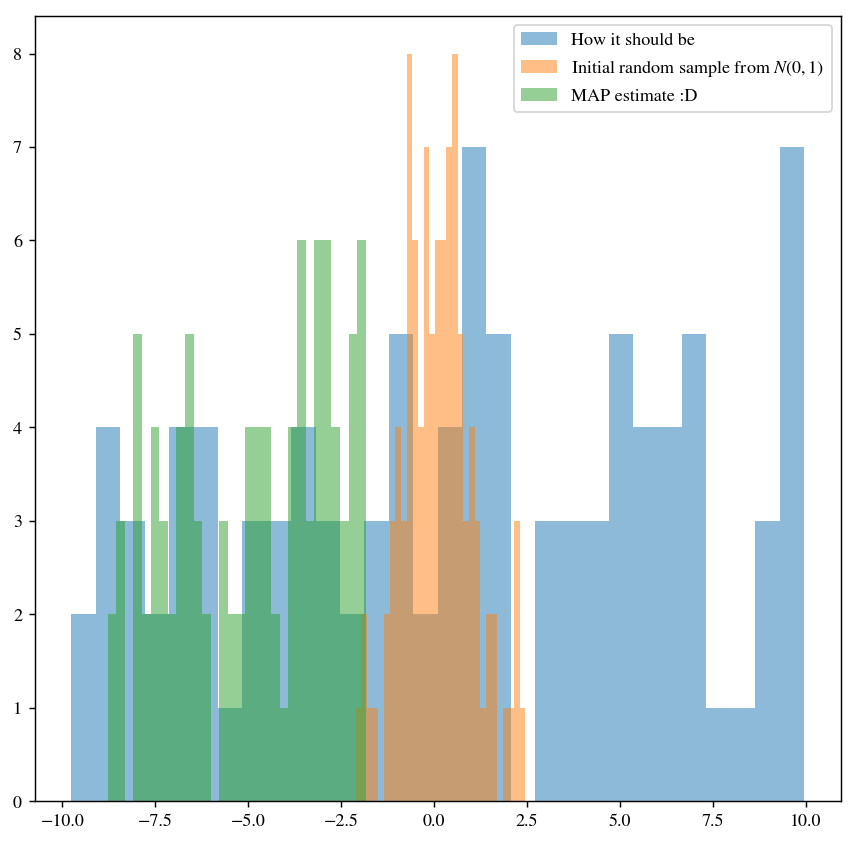

In [73]:
plt.figure(figsize=(8, 8), dpi=130)
plt.hist(x_r[:batch_size].view(-1), bins=30, label='How it should be', alpha=0.5);
plt.hist(x_r_batch_old.view(-1).cpu().detach().numpy(), bins=30, alpha=0.5, label='Initial random sample from $N(0, 1)$');
plt.hist(x_r_batch.view(-1).cpu().detach().numpy(), bins=30, alpha=0.5, label='MAP estimate :D');
plt.legend()
plt.show()

### HMC

In [191]:
class HybridMC(nn.Module):
    def __init__(self, model, dim_q, L, epsilon, q=None, covariance='unit', t=1.):
        super(HybridMC, self).__init__()
        self._model = model
        self._epsilon = epsilon
        if q is not None:
            self._q = torch.tensor(q).float().to(device)
        else:
            self._q = torch.zeros(dim_q, requires_grad=True)
        self._p = torch.zeros_like(self._q)
        self._N = len(self._q)
        self._L = L
        self._t = t
        if covariance == 'unit':
            self._mean_p = torch.zeros(dim_q).to(device)
            self._cov_p = torch.eye(dim_q).to(device)
        
    def calc_grad_q(self):
        q = self._q.clone().detach()
        q.requires_grad = True
        loss = self._model(q) / self._t
        loss.backward()
        return q.grad
        
    def step(self, t=1.):
        self._t = t
        self._p = dist.MultivariateNormal(self._mean_p, covariance_matrix=self._cov_p).sample([self._N])
        q_old = self._q.clone().detach()
        p_old = self._p.clone().detach()
        # leap frogs steps
        for i in range(self._L):
            self._p = self._p - (self._epsilon / 2) * self.calc_grad_q()
            self._q = self._q + self._epsilon * self._p
            self._p = self._p - (self._epsilon / 2) * self.calc_grad_q()
            
        # metropolis acceptance step
        with torch.no_grad():
            H_end = (self._model(self._q) / self._t + self._p.pow(2).sum()).item()
            H_start = (self._model(q_old) / self._t + p_old.pow(2).sum()).item()
        
        acc_prob = min(1, np.exp(H_start - H_end))
        if not np.random.binomial(1, acc_prob):
            self._q = q_old.clone().detach()
        return self._q
    
class IntermediateModel(nn.Module):
    def __init__(self, model, partial_condition, dim_in, y, device):
        super(IntermediateModel, self).__init__()
        self._y = y
        self._model = model
        self._dim_in = dim_in
        self._partial_condition = partial_condition
        self.device = device
    
    def forward(self, condition: torch.Tensor):
        conditions = torch.cat([
            self._partial_condition,
            condition, 
        ], dim=1)
        
        log_loss = self._model(self._y, condition=conditions)
        return -log_loss.mean()

In [199]:
x_r_batch = torch.randn(batch_size, 1, requires_grad=True, device=device)
x_r_batch_old = x_r_batch.detach().clone().to(device)
y_r_batch = y[:batch_size].detach().to(device)
mu_r_batch = mu_r[:batch_size].detach().to(device)

In [200]:
sample_fn, density_fn = get_transforms(model)
int_model = IntermediateModel(density_fn, 
                              partial_condition=mu_r_batch, 
                              y=y_r_batch, 
                              dim_in=1, 
                              device=device).to(device)

In [201]:
hmc_prototype = HybridMC(int_model, dim_q=1, L=20, q=x_r_batch, epsilon=0.05).to(device)

In [202]:
x_r_batch.mean().item(), int_model(x_r_batch)

(-0.08208425343036652, tensor(-0.1333, device='cuda:1', grad_fn=<NegBackward>))

In [203]:
from tqdm import tqdm
x_hist = []

for i in tqdm(range(1000)):
    x_hist.append(hmc_prototype.step( t=0.1 ))
    print(
        x_hist[-1].mean().item(), 
        len(x_hist), 
        int_model(x_hist[-1]).item()
    )











  0%|          | 0/1000 [00:00<?, ?it/s]









  0%|          | 1/1000 [00:24<6:49:37, 24.60s/it]

-0.08208425343036652 1 -0.13328510522842407












  0%|          | 2/1000 [00:48<6:46:37, 24.45s/it]

0.06442251801490784 2 -0.06495241075754166












  0%|          | 3/1000 [01:14<6:50:34, 24.71s/it]

0.26511022448539734 3 -0.03498992696404457












  0%|          | 4/1000 [01:38<6:50:49, 24.75s/it]

0.36204543709754944 4 -0.004225616343319416












  0%|          | 5/1000 [02:04<6:54:03, 24.97s/it]

0.38198593258857727 5 -0.0265984907746315












  1%|          | 6/1000 [02:29<6:54:10, 25.00s/it]

0.5004627108573914 6 0.03340962156653404












  1%|          | 7/1000 [02:55<6:58:49, 25.31s/it]

0.4084298610687256 7 0.020867491140961647












  1%|          | 8/1000 [03:20<6:56:33, 25.19s/it]

0.4084298610687256 8 0.020867491140961647












  1%|          | 9/1000 [03:45<6:54:16, 25.08s/it]

0.47761499881744385 9 0.0039137075655162334












  1%|          | 10/1000 [04:10<6:55:04, 25.16s/it]

0.5355534553527832 10 0.0020153236109763384












  1%|          | 11/1000 [04:35<6:54:24, 25.14s/it]

0.49331966042518616 11 0.00663660978898406












  1%|          | 12/1000 [05:01<6:55:49, 25.25s/it]

0.4961232542991638 12 0.0022783088497817516












  1%|▏         | 13/1000 [05:25<6:48:43, 24.85s/it]

0.6092751026153564 13 0.07606376707553864












  1%|▏         | 14/1000 [05:50<6:49:09, 24.90s/it]

0.46924543380737305 14 0.03034893050789833












  2%|▏         | 15/1000 [06:15<6:49:20, 24.93s/it]

0.35792624950408936 15 -0.020987024530768394












  2%|▏         | 16/1000 [06:38<6:43:37, 24.61s/it]

0.33256030082702637 16 -0.00954639445990324












  2%|▏         | 17/1000 [07:03<6:45:23, 24.74s/it]

0.2911989390850067 17 -0.004355907440185547












  2%|▏         | 18/1000 [07:30<6:51:51, 25.16s/it]

0.33668434619903564 18 0.012361754663288593












  2%|▏         | 19/1000 [07:54<6:46:22, 24.85s/it]

0.3035445809364319 19 0.03543557971715927












  2%|▏         | 20/1000 [08:19<6:47:16, 24.93s/it]

0.3871139585971832 20 0.0371362678706646












  2%|▏         | 21/1000 [08:45<6:52:43, 25.30s/it]

0.49324560165405273 21 0.08819010853767395












  2%|▏         | 22/1000 [09:10<6:49:10, 25.10s/it]

0.5602940917015076 22 0.1274416446685791












  2%|▏         | 23/1000 [09:35<6:48:27, 25.08s/it]

0.5602940917015076 23 0.1274416446685791












  2%|▏         | 24/1000 [10:00<6:46:59, 25.02s/it]

0.5602940917015076 24 0.1274416446685791












  2%|▎         | 25/1000 [10:25<6:49:41, 25.21s/it]

0.6362999677658081 25 0.15478432178497314












  3%|▎         | 26/1000 [10:50<6:45:39, 24.99s/it]

0.7625381350517273 26 0.18734778463840485












  3%|▎         | 27/1000 [11:14<6:40:26, 24.69s/it]

0.9029922485351562 27 0.19924278557300568












  3%|▎         | 28/1000 [11:38<6:39:39, 24.67s/it]

0.9935871958732605 28 0.18738672137260437












  3%|▎         | 29/1000 [12:02<6:36:43, 24.51s/it]

0.8825744390487671 29 0.16109351813793182












  3%|▎         | 30/1000 [12:27<6:36:49, 24.55s/it]

0.8842052221298218 30 0.1413205862045288












  3%|▎         | 31/1000 [12:54<6:45:27, 25.11s/it]

0.8943302631378174 31 0.17215639352798462












  3%|▎         | 32/1000 [13:18<6:41:14, 24.87s/it]

1.0693284273147583 32 0.21937891840934753












  3%|▎         | 33/1000 [13:42<6:39:32, 24.79s/it]

1.0693284273147583 33 0.21937891840934753












  3%|▎         | 34/1000 [14:07<6:40:08, 24.85s/it]

1.0336076021194458 34 0.23257865011692047












  4%|▎         | 35/1000 [14:33<6:42:20, 25.02s/it]

1.0336076021194458 35 0.23257865011692047












  4%|▎         | 36/1000 [14:58<6:40:28, 24.93s/it]

0.9328483939170837 36 0.2141897976398468












  4%|▎         | 37/1000 [15:21<6:34:59, 24.61s/it]

0.9328483939170837 37 0.2141897976398468












  4%|▍         | 38/1000 [15:47<6:38:29, 24.85s/it]

0.9328483939170837 38 0.2141897976398468












  4%|▍         | 39/1000 [16:11<6:34:58, 24.66s/it]

0.9328483939170837 39 0.2141897976398468












  4%|▍         | 40/1000 [16:36<6:34:46, 24.67s/it]

1.0167732238769531 40 0.21202567219734192












  4%|▍         | 41/1000 [17:00<6:32:19, 24.55s/it]

1.010854959487915 41 0.22490891814231873












  4%|▍         | 42/1000 [17:24<6:31:04, 24.49s/it]

1.0340958833694458 42 0.23781943321228027












  4%|▍         | 43/1000 [17:49<6:29:35, 24.43s/it]

1.090659737586975 43 0.24781553447246552












  4%|▍         | 44/1000 [18:14<6:33:31, 24.70s/it]

1.1413474082946777 44 0.2297177016735077












  4%|▍         | 45/1000 [18:40<6:37:19, 24.96s/it]

1.184898853302002 45 0.25212427973747253












  5%|▍         | 46/1000 [19:04<6:36:41, 24.95s/it]

1.212673306465149 46 0.2713063955307007












  5%|▍         | 47/1000 [19:29<6:32:07, 24.69s/it]

1.1229603290557861 47 0.1918904036283493












  5%|▍         | 48/1000 [19:53<6:30:38, 24.62s/it]

1.1229603290557861 48 0.1918904036283493












  5%|▍         | 49/1000 [20:20<6:39:33, 25.21s/it]

1.1594597101211548 49 0.1714918166399002












  5%|▌         | 50/1000 [20:44<6:37:29, 25.11s/it]

1.1589916944503784 50 0.1596716195344925












  5%|▌         | 51/1000 [21:11<6:44:06, 25.55s/it]

1.252761721611023 51 0.14754615724086761












  5%|▌         | 52/1000 [21:37<6:47:08, 25.77s/it]

1.1752532720565796 52 0.11083342134952545












  5%|▌         | 53/1000 [22:02<6:42:14, 25.48s/it]

1.1891380548477173 53 0.1351892054080963












  5%|▌         | 54/1000 [22:26<6:35:23, 25.08s/it]

1.1508641242980957 54 0.12398040294647217












  6%|▌         | 55/1000 [22:51<6:33:11, 24.96s/it]

1.192362666130066 55 0.10343907028436661












  6%|▌         | 56/1000 [23:15<6:30:24, 24.81s/it]

1.2072277069091797 56 0.12142369151115417












  6%|▌         | 57/1000 [23:40<6:27:53, 24.68s/it]

1.277516484260559 57 0.11652343720197678












  6%|▌         | 58/1000 [24:05<6:29:22, 24.80s/it]

1.3075063228607178 58 0.14064830541610718












  6%|▌         | 59/1000 [24:30<6:29:50, 24.86s/it]

1.2825474739074707 59 0.1320466250181198












  6%|▌         | 60/1000 [24:54<6:26:43, 24.69s/it]

1.2702093124389648 60 0.159408301115036












  6%|▌         | 61/1000 [25:20<6:29:35, 24.89s/it]

1.2744240760803223 61 0.14857734739780426












  6%|▌         | 62/1000 [25:46<6:34:56, 25.26s/it]

1.3572442531585693 62 0.1724066138267517












  6%|▋         | 63/1000 [26:11<6:34:35, 25.27s/it]

1.1882926225662231 63 0.13424773514270782












  6%|▋         | 64/1000 [26:36<6:32:27, 25.16s/it]

1.1458768844604492 64 0.11919195204973221












  6%|▋         | 65/1000 [27:01<6:30:39, 25.07s/it]

1.1458768844604492 65 0.11919195204973221












  7%|▋         | 66/1000 [27:25<6:27:30, 24.89s/it]

1.2805722951889038 66 0.17376960813999176












  7%|▋         | 67/1000 [27:50<6:28:49, 25.00s/it]

1.4043978452682495 67 0.19891078770160675












  7%|▋         | 68/1000 [28:16<6:29:39, 25.09s/it]

1.5162001848220825 68 0.2243696004152298












  7%|▋         | 69/1000 [28:40<6:25:37, 24.85s/it]

1.490020513534546 69 0.18962478637695312












  7%|▋         | 70/1000 [29:04<6:22:34, 24.68s/it]

1.490020513534546 70 0.18962478637695312












  7%|▋         | 71/1000 [29:29<6:20:00, 24.54s/it]

1.4145065546035767 71 0.17993313074111938












  7%|▋         | 72/1000 [29:53<6:17:46, 24.42s/it]

1.3421348333358765 72 0.1425478756427765












  7%|▋         | 73/1000 [30:17<6:16:26, 24.37s/it]

1.405420184135437 73 0.14692071080207825












  7%|▋         | 74/1000 [30:41<6:15:28, 24.33s/it]

1.5060689449310303 74 0.14097270369529724












  8%|▊         | 75/1000 [31:07<6:20:01, 24.65s/it]

1.462880253791809 75 0.15530084073543549












  8%|▊         | 76/1000 [31:31<6:18:03, 24.55s/it]

1.4115900993347168 76 0.1547032743692398












  8%|▊         | 77/1000 [31:55<6:16:16, 24.46s/it]

1.4130316972732544 77 0.16548635065555573












  8%|▊         | 78/1000 [32:21<6:20:19, 24.75s/it]

1.5662930011749268 78 0.22125424444675446












  8%|▊         | 79/1000 [32:46<6:22:55, 24.95s/it]

1.7023440599441528 79 0.2249525934457779












  8%|▊         | 80/1000 [33:10<6:20:37, 24.82s/it]

1.7023440599441528 80 0.2249525934457779












  8%|▊         | 81/1000 [33:35<6:18:23, 24.70s/it]

1.7606196403503418 81 0.23674865067005157












  8%|▊         | 82/1000 [33:59<6:16:27, 24.60s/it]

1.7606196403503418 82 0.23674865067005157












  8%|▊         | 83/1000 [34:23<6:13:53, 24.46s/it]

1.7748093605041504 83 0.20896483957767487












  8%|▊         | 84/1000 [34:48<6:13:30, 24.47s/it]

1.8083248138427734 84 0.20520059764385223












  8%|▊         | 85/1000 [35:13<6:16:16, 24.67s/it]

1.8536467552185059 85 0.20685042440891266












  9%|▊         | 86/1000 [35:40<6:25:18, 25.29s/it]

1.8234702348709106 86 0.1781744509935379












  9%|▊         | 87/1000 [36:05<6:24:02, 25.24s/it]

1.8296029567718506 87 0.16591228544712067












  9%|▉         | 88/1000 [36:31<6:28:58, 25.59s/it]

1.7190022468566895 88 0.1249065175652504












  9%|▉         | 89/1000 [36:56<6:22:38, 25.20s/it]

1.5718271732330322 89 0.10378368943929672












  9%|▉         | 90/1000 [37:21<6:25:07, 25.39s/it]

1.4220632314682007 90 0.0914011299610138












  9%|▉         | 91/1000 [37:47<6:23:09, 25.29s/it]

1.6361089944839478 91 0.1570279449224472












  9%|▉         | 92/1000 [38:12<6:22:56, 25.30s/it]

1.6315276622772217 92 0.11665477603673935












  9%|▉         | 93/1000 [38:36<6:19:28, 25.10s/it]

1.7609057426452637 93 0.1808486133813858












  9%|▉         | 94/1000 [39:01<6:16:02, 24.90s/it]

1.7850744724273682 94 0.1852116584777832












 10%|▉         | 95/1000 [39:26<6:15:36, 24.90s/it]

1.743860125541687 95 0.17336559295654297












 10%|▉         | 96/1000 [39:51<6:16:33, 24.99s/it]

1.6678930521011353 96 0.15584978461265564












 10%|▉         | 97/1000 [40:15<6:13:43, 24.83s/it]

1.5022823810577393 97 0.13648250699043274












 10%|▉         | 98/1000 [40:40<6:13:32, 24.85s/it]

1.665194034576416 98 0.16936194896697998












 10%|▉         | 99/1000 [41:05<6:13:09, 24.85s/it]

1.82473623752594 99 0.16746929287910461












 10%|█         | 100/1000 [41:30<6:11:19, 24.76s/it]

1.839882254600525 100 0.14896808564662933












 10%|█         | 101/1000 [41:55<6:14:59, 25.03s/it]

1.7655161619186401 101 0.1178734079003334












 10%|█         | 102/1000 [42:20<6:13:32, 24.96s/it]

1.7060375213623047 102 0.10786115378141403












 10%|█         | 103/1000 [42:45<6:11:28, 24.85s/it]

1.7763792276382446 103 0.0806768611073494












 10%|█         | 104/1000 [43:10<6:14:19, 25.07s/it]

1.899067997932434 104 0.0778001993894577












 10%|█         | 105/1000 [43:36<6:15:56, 25.20s/it]

2.0969362258911133 105 0.09242919832468033












 11%|█         | 106/1000 [44:01<6:13:37, 25.08s/it]

2.002429485321045 106 0.0638994574546814












 11%|█         | 107/1000 [44:25<6:08:54, 24.79s/it]

1.9145231246948242 107 0.041293371468782425












 11%|█         | 108/1000 [44:50<6:09:00, 24.82s/it]

1.9015125036239624 108 0.058877162635326385












 11%|█         | 109/1000 [45:15<6:09:02, 24.85s/it]

1.8408269882202148 109 0.03658634051680565












 11%|█         | 110/1000 [45:41<6:13:35, 25.19s/it]

1.9642802476882935 110 0.02841348573565483












 11%|█         | 111/1000 [46:05<6:10:32, 25.01s/it]

1.9443001747131348 111 0.06522838771343231












 11%|█         | 112/1000 [46:31<6:14:12, 25.28s/it]

2.0224413871765137 112 0.0801054909825325












 11%|█▏        | 113/1000 [46:55<6:09:42, 25.01s/it]

2.07218861579895 113 0.10149596631526947












 11%|█▏        | 114/1000 [47:20<6:06:45, 24.84s/it]

2.111737012863159 114 0.08121772855520248












 12%|█▏        | 115/1000 [47:45<6:07:45, 24.93s/it]

2.1795194149017334 115 0.07451838999986649












 12%|█▏        | 116/1000 [48:12<6:15:50, 25.51s/it]

2.048421621322632 116 0.06068095937371254












 12%|█▏        | 117/1000 [48:37<6:15:26, 25.51s/it]

1.94384765625 117 0.04361835494637489


KeyboardInterrupt: 

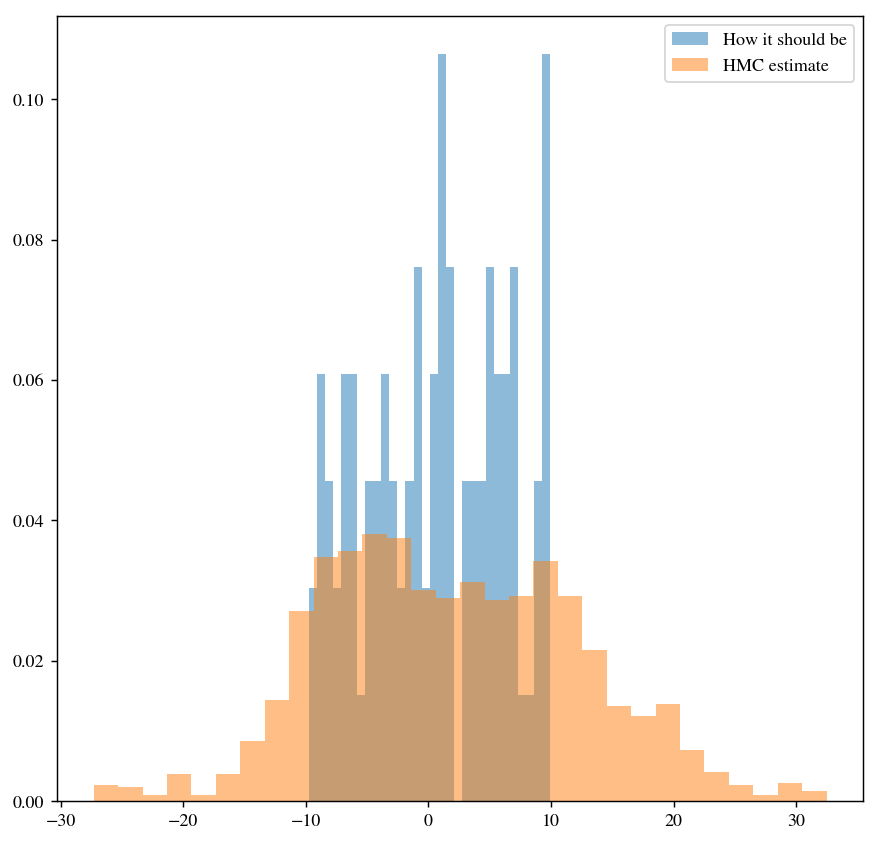

In [224]:
plt.figure(figsize=(8, 8), dpi=130)

plt.hist(x_r[:batch_size].view(-1), bins=30, label='How it should be', density=True, alpha=0.5);
plt.hist(torch.cat(x_hist[100:]).view(-1).view(-1).cpu().detach().numpy(), bins=30, alpha=0.5, density=True, label='HMC estimate');
plt.legend()
plt.show()